In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [3]:
# dataframe = read_csv('sp500.csv')
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039


In [4]:
# dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [5]:
split = 0.67
train_size = int(len(data)*split)
test_size = len(data)-train_size
train = data[0:train_size,:]
test = data[train_size:len(data),:]
print(train[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [6]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
# print(trainY[:5])

(839, 3, 2)


In [7]:
look_forward = 3

In [8]:
# trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

In [9]:
units = 100
drop = 0.2
epoch = 20

In [10]:
model = load_model("./Models/PricePrediction.h5")

In [44]:
model = Sequential()
model.add(LSTM(units, input_shape=(look_back, 2)))
# model.add(Dropout(drop))
model.add(Dense(2))
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='nadam')
model.summary()
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
839/839 [==============================] - 6s 7ms/step - loss: 0.0013
Epoch 2/20
839/839 [==============================] - 4s 5ms/step - loss: 3.5457e-04
Epoch 3/20
839/839 [==============================] - 4s 5ms/step - loss: 3.1603e-04
Epoch 4/20
839/839 [==============================] - 4s 5ms/step - loss: 2.7183e-04
Epoch 5/20
839/839 [==============================] - 4s 5ms/step - loss: 2.5292e-04
Epoch 6/20
839/839 [==============================] - 4s 5ms/step - loss: 1.9904e-04
Epoch 7/20
839/839 [========

In [45]:
model.save("./Models/PricePrediction.h5")

In [46]:
a = trainX[0]
a = a.reshape((1, a.shape[0], a.shape[1]))
# print(a.shape)
a_next = model.predict(a)
print(a_next)
# model.predict(a)
# print(trainX[: 5])
# print(trainX[0])
# trainX.shape

[[0.00492746 0.0081273 ]]


In [67]:
a = trainX[0]

In [17]:
a.shape

(1, 3, 2)

In [74]:
# x1 = [a[0][1], a[0][2]]
a = trainX[0]
a[0][1]

0.012108253960359139

In [36]:
col = 0

In [115]:
# all_pred = np.zeros((len(trainX)//10, 2))
all_pred = []
print(type(all_pred))

<class 'list'>


In [116]:
for i in range(0, len(trainX), 10):
#     print(i)
    forward_window = []
    # a = trainX[0]
    # a = a.reshape((1, a.shape[0], a.shape[1]))
    # forward_window.append(a)

    # a = a.reshape((1, a.shape[0], a.shape[1]))
    base = trainX[i]
    base = base.reshape((1, base.shape[0], base.shape[1]))
    for j in range(look_forward):
        next_pred = model.predict(base)
        forward_window.append(next_pred)

        next_temp = np.zeros((1, look_forward, base.shape[2]))
        for k in range(look_forward-1):
            next_temp[0][k] = a[0][k+1]

        next_temp[0][look_forward-1] = next_pred
        base = next_temp

    forward_window.append(model.predict(base))

    # b = model.predict(a)
    # forward_window.append(b)

    # b1 = np.zeros((1, look_forward, a.shape[2]))
    # b1[0][0] = a[0][1]
    # b1[0][1] = a[0][2]
    # b1[0][2] = b
    # # b1 = [int(a[0][1]), int(a[0][2]), b]
    # # a = a.reshape((1, a.shape[0], a.shape[1]))
    # c = model.predict(b1)
    # forward_window.append(c)

    # # a = a.reshape((1, a.shape[0], a.shape[1]))
    # c1 = np.zeros((1, look_forward, 2))
    # c1[0][0] = b1[0][1]
    # c1[0][1] = b1[0][2]
    # c1[0][2] = c

    # # c1 = [b1[0][1], b1[0][2], c]

    # d = model.predict(c1)
    # forward_window.append(d)
    pred_steps = np.concatenate(forward_window, axis = 0)
#     all_pred[i] = pred_steps
#     print(type(np.ndarray.tolist(pred_steps)))
#     print(type(next_pred))
    all_pred.append(np.ndarray.tolist(pred_steps))
    
#     next_pred[i] = pred_steps
#     X = np.arange(i, i+4)
#     Y = pred_steps[:, col]
#     plt.plot(X, Y)
# plt.show()

In [117]:
all_pred = np.asarray(all_pred)
all_pred.shape

(84, 4, 2)

In [22]:
T = np.concatenate(forward_window, axis = 0)

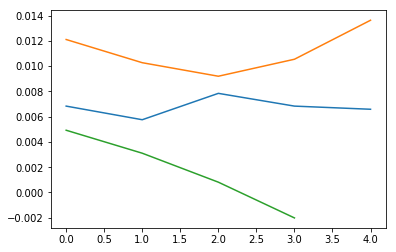

In [32]:
# T = [0, 0, 0]
# col = 0
# T[0] = forward_window[0][col][col]
# T[1] = forward_window[1][col][col]
# T[2] = forward_window[2][col][col]
# print(T)
plt.plot(train[:5])
plt.plot(T[:, 0])
plt.show()

In [82]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [83]:
trainPredict.shape

(839, 2)

In [118]:
bkup = all_pred

In [121]:
for i in range(all_pred.shape[0]):
    all_pred[i] = scaler.inverse_transform(all_pred[i])
#     for j in i:
#     print(scaler.inverse_transform(all_pred[i]))

In [122]:
all_pred

array([[[ 388.92152789,  389.87613876],
        [ 387.46129141,  388.38043321],
        [ 385.62056694,  386.54547793],
        [ 383.34916243,  384.2803817 ]],

       [[ 399.29701422,  400.08617269],
        [ 400.15540072,  401.04118064],
        [ 401.31225915,  402.19323241],
        [ 402.74241869,  403.6193899 ]],

       [[ 411.93095768,  412.63100071],
        [ 415.75229103,  416.59491612],
        [ 420.63913314,  421.46547879],
        [ 426.70257784,  427.5117373 ]],

       [[ 399.21135446,  400.03969348],
        [ 400.08667308,  400.97202805],
        [ 401.22662931,  402.10784175],
        [ 402.63645236,  403.51371066]],

       [[ 392.99751907,  393.98190056],
        [ 392.53586462,  393.44018432],
        [ 391.88757995,  392.79501185],
        [ 391.08778575,  391.99744123]],

       [[ 402.99732781,  403.88843846],
        [ 404.84253959,  405.71335131],
        [ 407.11287911,  407.97752479],
        [ 409.92532756,  410.78205433]],

       [[ 433.40880277,  434

In [23]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

NameError: name 'trainPredict' is not defined

In [235]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 8.64 RMSE
Test Score: 17.13 RMSE


In [236]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict


In [237]:
# print(data.shape)
# print(train.shape)
# print(test.shape)
# print(trainPredict.shape)
# print(testPredict.shape)

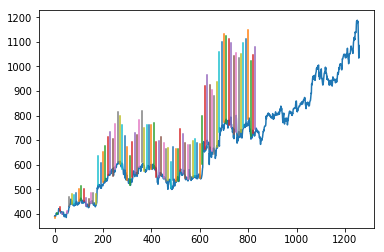

In [130]:
col = 0
plt.plot(scaler.inverse_transform(data)[:,col])
for i in range(all_pred.shape[0]):
    X = np.ones(look_forward+1)*(i*10)
    Y = all_pred[i][:, col]
    plt.plot(X, Y)
# plt.plot(trainPredictPlot[:,col])
# plt.plot(testPredictPlot[:,col])
# plt.title('Units = %d Dropout = %.2f Epoch = %d Split = %d%% Train = %.2f Test = %.2f' % 
# 		(units, drop, epoch, split*100, trainScore, testScore))
plt.show()